In [1]:
import numpy as np
from catboost import Pool, CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt

Assume that we have two categorical features with 9 values each, so there are 81 possible feature combinations. The target depends on the features as y = mean(x) + eps(x), where mean(x) is some unknown fixed value and eps(x) is a normally distributed noise with mean 0 and variance var(x). We let mean(x) to be randomly generated and var(x) to have two values - 0.1 and 0.2. Also, there will be an "unknown" region without any training examples. To indicate this region on the figure, we set var(x) = 0.

In [2]:
# function for generating mean and variance
def gen_parameters(noise=0.1):
    
    mean = np.random.rand(9, 9)
    
    figure = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 2, 1, 1, 1, 2, 1, 1],
        [1, 2, 0, 2, 1, 2, 0, 2, 1],
        [2, 0, 0, 0, 2, 0, 0, 0, 2],
        [1, 2, 0, 0, 0, 0, 0, 2, 1],
        [1, 1, 2, 0, 0, 0, 2, 1, 1],
        [1, 1, 1, 2, 0, 2, 1, 1, 1],
        [1, 1, 1, 1, 2, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]
    ])

    var = figure*noise
    
    return mean, var

True data uncertainty (variance). The white region will not contain any traing data.


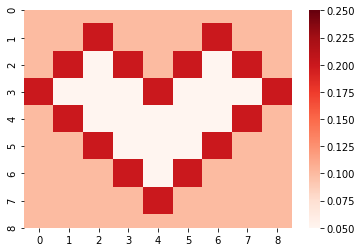

In [3]:
# generate parameters and plot the variance
mean, var = gen_parameters()
print("True data uncertainty (variance). The white region will not contain any traing data.")
sns.heatmap(var, cmap="Reds", vmin = 0.05, vmax = 0.25)
plt.show()

In [4]:
# function for generating train and validation sets
def generate_training_data(n_samples, mean, var, num_cat=9):
    train = []
    target = []
    val = []
    val_target = []
    for i in range(num_cat):
        for j in range(num_cat):
            if var[i, j] == 0:
                continue
            for _ in range(n_samples):
                train.append([i, j])
                val.append([i, j])
                target.append(np.random.normal(mean[i, j], var[i, j]))
                val_target.append(np.random.normal(mean[i, j], var[i, j]))
                
    train = np.asarray(train)
    target = np.asarray(target)

    return train, target, val, val_target

Now we generate the dataset using the obtained distribution. In each cell, except for the white ones, we have several training examples. The test set consists of all possible feature combinations.

In [5]:
# generate train and validation datasets
train, target, val, val_target = generate_training_data(1000, mean, var)

train_pool = Pool(train, target, cat_features = [0, 1])
val_pool = Pool(val, val_target, cat_features = [0, 1])

# generate test, consisting of all possible feature combinations
num_cat = 9
test = np.asarray([[i, j] for i in range(num_cat) for j in range(num_cat)])

If we optimize the RMSE loss, then we predict mean(x). If we want to estimate var(x) (data uncertainty), then we have to use a probabilistic regression model that predicts mean and variance. For this purpose, we can use the loss function called RMSEWithUncertainty. Below we can see that CatBoost is able to predict the variance outside the heart and on its border. Inside the heart we have no training data, so anything can be predicted there.

best iteration = 924
Predicted data uncertainty:


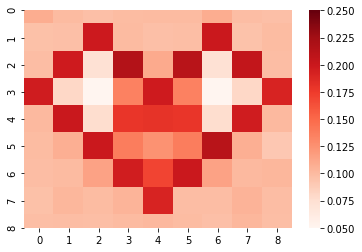

In [6]:
# predict data uncertainty

model = CatBoostRegressor(iterations=1000, learning_rate=0.2, 
                          loss_function='RMSEWithUncertainty', verbose=False)

model.fit(train_pool, eval_set=val_pool)
print("best iteration =", model.get_best_iteration())
preds = model.predict(test)

mean_preds = preds[:, 0]
var_preds = preds[:, 1]

print("Predicted data uncertainty:")

sns.heatmap(var_preds.reshape([num_cat, num_cat]), cmap="Reds", vmin=0.05, vmax=0.25)
plt.show()

Ok, we know how to estimate noise in the data. But how to measure knowledge uncertainty coming from the lack of training data in a particular region? What to do if we want to detect outliers?  Estimating knowledge uncertainty requires an ensemble of models. If all the models give similar predictions, then there is low knowledge uncertainty, and if they give diverse predictions (strongly disagree with each other), then there is high knowledge uncertainty. Let’s generate an ensemble:

In [7]:
def ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr=0.2):
    ens_preds = []
    for seed in range(num_samples):
        model = CatBoostRegressor(random_seed=seed, iterations=iters, learning_rate=lr, 
                                  loss_function='RMSEWithUncertainty', posterior_sampling=True,
                                  verbose=False)
        model.fit(train_pool, eval_set=val_pool)
        ens_preds.append(model.predict(test))
    return ens_preds

Note that the models are generated using the option posterior_sampling, since this allows the obtained (random) predictions to be nicely distributed (with good theoretical properties).

For regression, knowledge uncertainty can be obtained by measuring the variance of the mean across multiple models. Note that this is different from the predicted variance, which captures data uncertainty.

Knowledge uncertainty via ensemble:


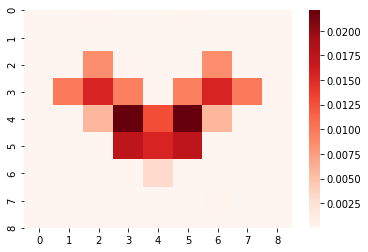

In [8]:
ens_preds = ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr=0.2)
ens_preds = np.asarray(ens_preds)
knowledge = np.var(ens_preds, axis=0)[:, 0]

print("Knowledge uncertainty via ensemble:")            
sns.heatmap(knowledge.reshape([num_cat, num_cat]), cmap="Reds")
plt.show()

The model perfectly detected knowledge uncertainty inside the heart (we can see no traces of the original heart border on the figure). This illustrates how by estimating knowledge uncertainty, we can detect anomalous inputs.

In practice, training an ensemble of several CatBoost models can be too expensive. If you need a cheaper method - you can use a virtual ensemble, obtained from a single trained model:

In [9]:
def virt_ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr=0.2):
    ens_preds = []
    model = CatBoostRegressor(iterations=iters, learning_rate=lr, loss_function='RMSEWithUncertainty', 
                              posterior_sampling=True, verbose=False)
    model.fit(train_pool, eval_set=val_pool)
    ens_preds = model.virtual_ensembles_predict(test, prediction_type='VirtEnsembles', virtual_ensembles_count=num_samples)
    return ens_preds

As before, knowledge uncertainty can be obtained by measuring the variance of the mean across the obtained models:

Knowledge uncertainty, virtual


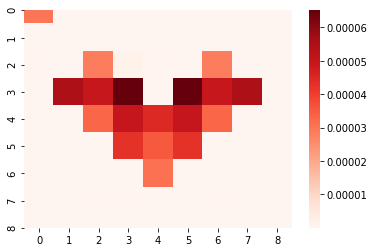

In [10]:
ens_preds = virt_ensemble(train_pool, val_pool, num_samples=10, iters=1000, lr=0.2)

ens_preds = np.asarray(ens_preds)
ens_preds = ens_preds.reshape((81, 10, 2))

knowledge = np.var(ens_preds, axis = 1)[:,0]

print("Knowledge uncertainty, virtual")
sns.heatmap(knowledge.reshape([num_cat,num_cat]), cmap="Reds")
plt.show()

We can also use prediction_type='TotalUncertainty' and get the same result easier:

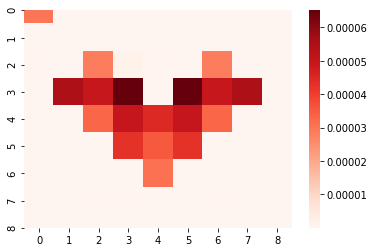

In [11]:
model = CatBoostRegressor(iterations=1000, learning_rate=0.2, loss_function='RMSEWithUncertainty', 
                          posterior_sampling=True, verbose=False)
model.fit(train_pool, eval_set=val_pool)
preds = model.virtual_ensembles_predict(test, prediction_type='TotalUncertainty', virtual_ensembles_count=10)
knowledge = preds[:,1]

sns.heatmap(knowledge.reshape([num_cat,num_cat]), cmap="Reds")
plt.show()